In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dataset = dsets.MNIST(root='./data', 
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = dsets.MNIST(root='./data', 
                           train=False, 
                           transform=transforms.ToTensor())

Create training and test set with 500 examples of classes 5 and 8 respectively and change labels to 0 and 1. At the same time flip 30% of the labels.

In [3]:
train_set = [ex for ex in train_dataset if ex[1]==5][:500] + [ex for ex in train_dataset if ex[1]==8][:500]
test_set = [ex for ex in test_dataset if ex[1]==5][:500] + [ex for ex in test_dataset if ex[1]==8][:500]

In [4]:
train_set_01_images = []
test_set_01_images = []
train_set_01_labels = []
test_set_01_labels = []
num_flips = 500//3 #num_flips=0 to have no flips
for i,ex_tr in enumerate(train_set):
    ex_tr = list(ex_tr)
    if ex_tr[1]==5:
        if i<num_flips:
            ex_tr[1]=1
        else: 
            ex_tr[1]=0
    else: 
        if i<num_flips+500:
            ex_tr[1]=0
        else: 
            ex_tr[1]=1
    train_set_01_images.append(ex_tr[0])
    train_set_01_labels.append(ex_tr[1])
    
for ex_te in test_set:
    ex_te = list(ex_te)
    if ex_te[1]==5:
        ex_te[1]=0
    else: 
        ex_te[1]=1
    test_set_01_images.append(ex_te[0])
    test_set_01_labels.append(ex_te[1])    
    
train_set_01_images = torch.stack(train_set_01_images)
train_set_01_images = train_set_01_images.view(-1, 28*28)
test_set_01_images = torch.stack(test_set_01_images)
test_set_01_images = test_set_01_images.view(-1, 28*28)
train_set_01_labels = torch.tensor(train_set_01_labels)
test_set_01_labels = torch.tensor(test_set_01_labels)

# shuffle training set
n_sample = len(train_set_01_images)
np.random.seed(0)
order = np.random.permutation(n_sample)
train_set_01_images = train_set_01_images[order]
train_set_01_labels = train_set_01_labels[order]

In [5]:
print("size train set:", train_set_01_images.shape) 
print("size test set:", test_set_01_images.shape)

size train set: torch.Size([1000, 784])
size test set: torch.Size([1000, 784])


## Part 1

In [6]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        out = self.linear(x)
        return out

In [7]:
accuracy_tr_list = []
accuracy_te_list = []

input_dim = 28*28
output_dim = 2

model = LogisticRegressionModel(input_dim, output_dim)
learning_rate = 0.01
n_iter = 10000
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
criterion = nn.CrossEntropyLoss()  

# Choose the data sets used for training and testing
images_test = test_set_01_images
labels_test = test_set_01_labels
images_train = train_set_01_images
labels_train = train_set_01_labels

for iter in range(n_iter):
    # Training
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()
    
    outputs = model(images_train)

    # Loss: softmax + negative log likelihood loss
    loss = criterion(outputs, labels_train)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    
    _, predicted = torch.max(outputs.data, 1)
    total_tr = labels_train.size(0)
    correct_tr = (predicted == labels_train).sum()
    accuracy_tr = 100 * correct_tr / total_tr
    accuracy_tr_list.append(accuracy_tr)

    # Testing
    outputs = model(images_test)
    _, predicted = torch.max(outputs.data, 1)
    total = labels_test.size(0)
    correct = (predicted == labels_test).sum()

    accuracy = 100 * correct / total
    accuracy_te_list.append(accuracy)

    if iter % 500 == 0:
        print('Iteration: {}. Loss: {}. Test Accuracy: {}. Train Accuracy: {}'.format(iter, loss.item(), accuracy,accuracy_tr))

Iteration: 0. Loss: 0.6876462697982788. Test Accuracy: 51. Train Accuracy: 53
Iteration: 500. Loss: 0.6025997400283813. Test Accuracy: 85. Train Accuracy: 68
Iteration: 1000. Loss: 0.5888893604278564. Test Accuracy: 83. Train Accuracy: 69
Iteration: 1500. Loss: 0.5795310735702515. Test Accuracy: 82. Train Accuracy: 70
Iteration: 2000. Loss: 0.5720621347427368. Test Accuracy: 81. Train Accuracy: 71
Iteration: 2500. Loss: 0.5657334923744202. Test Accuracy: 80. Train Accuracy: 71
Iteration: 3000. Loss: 0.560198962688446. Test Accuracy: 80. Train Accuracy: 72
Iteration: 3500. Loss: 0.5552613139152527. Test Accuracy: 80. Train Accuracy: 72
Iteration: 4000. Loss: 0.5507935881614685. Test Accuracy: 79. Train Accuracy: 73
Iteration: 4500. Loss: 0.546707808971405. Test Accuracy: 79. Train Accuracy: 73
Iteration: 5000. Loss: 0.5429407954216003. Test Accuracy: 79. Train Accuracy: 73
Iteration: 5500. Loss: 0.5394429564476013. Test Accuracy: 78. Train Accuracy: 73
Iteration: 6000. Loss: 0.536177635

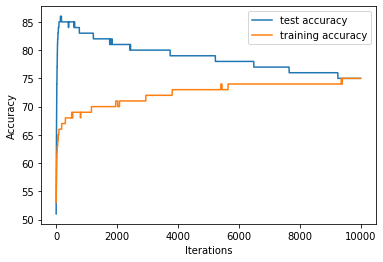

In [8]:
plt.plot(accuracy_te_list,label='test accuracy')
plt.plot(accuracy_tr_list,label='training accuracy')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
max(accuracy_te_list)

tensor(86)

## Part 2

In [10]:
# Random feature model
num_featurs = train_set_01_images.shape[1]
np.random.seed(0)
ReLU = nn.ReLU()
F = ReLU(torch.from_numpy( np.random.normal(loc=0, scale=1, size=[num_featurs,2*num_featurs]) ).type(torch.FloatTensor))
train_set_01_images_rf = train_set_01_images @ F
test_set_01_images_rf = test_set_01_images @ F

train_set_01_images_rf -= train_set_01_images_rf.mean(0)[None, :]
train_set_01_images_rf /= train_set_01_images_rf.std(0)[None, :]
test_set_01_images_rf -= test_set_01_images_rf.mean(0)[None, :]
test_set_01_images_rf /= test_set_01_images_rf.std(0)[None, :]

In [11]:
print("size train set:", train_set_01_images_rf.shape) 
print("size test set:", test_set_01_images_rf.shape)

size train set: torch.Size([1000, 1568])
size test set: torch.Size([1000, 1568])


In [12]:
accuracy_tr_list = []
accuracy_te_list = []

input_dim = 28*28*2
output_dim = 2

model = LogisticRegressionModel(input_dim, output_dim)
learning_rate = 0.001
n_iter = 10000
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 
criterion = nn.CrossEntropyLoss()  

# Choose the data sets used for training and testing
images_test = test_set_01_images_rf
labels_test = test_set_01_labels
images_train = train_set_01_images_rf
labels_train = train_set_01_labels

for iter in range(n_iter):
    # Training
    # Clear gradients w.r.t. parameters
    optimizer.zero_grad()

    outputs = model(images_train)

    # Calculate Loss: softmax + negative log likelihood loss
    loss = criterion(outputs, labels_train)

    # Getting gradients w.r.t. parameters
    loss.backward()

    # Updating parameters
    optimizer.step()
    
    _, predicted = torch.max(outputs.data, 1)
    total_tr = labels_train.size(0)
    correct_tr = (predicted == labels_train).sum()
    accuracy_tr = 100 * correct_tr / total_tr
    accuracy_tr_list.append(accuracy_tr)

    # Testing
    outputs = model(images_test)
    _, predicted = torch.max(outputs.data, 1)
    total = labels_test.size(0)
    correct = (predicted == labels_test).sum()

    accuracy = 100 * correct / total
    accuracy_te_list.append(accuracy)

    if iter % 500 == 0:
        print('Iteration: {}. Loss: {}. Test Accuracy: {}. Train Accuracy: {}'.format(iter, loss.item(), accuracy,accuracy_tr))

Iteration: 0. Loss: 0.7074114084243774. Test Accuracy: 62. Train Accuracy: 51
Iteration: 500. Loss: 0.6229381561279297. Test Accuracy: 88. Train Accuracy: 66
Iteration: 1000. Loss: 0.6108800172805786. Test Accuracy: 87. Train Accuracy: 67
Iteration: 1500. Loss: 0.603598415851593. Test Accuracy: 86. Train Accuracy: 69
Iteration: 2000. Loss: 0.5982382297515869. Test Accuracy: 86. Train Accuracy: 69
Iteration: 2500. Loss: 0.5939191579818726. Test Accuracy: 84. Train Accuracy: 69
Iteration: 3000. Loss: 0.5902423858642578. Test Accuracy: 84. Train Accuracy: 69
Iteration: 3500. Loss: 0.5869991779327393. Test Accuracy: 84. Train Accuracy: 70
Iteration: 4000. Loss: 0.5840677618980408. Test Accuracy: 84. Train Accuracy: 70
Iteration: 4500. Loss: 0.5813756585121155. Test Accuracy: 83. Train Accuracy: 70
Iteration: 5000. Loss: 0.5788739919662476. Test Accuracy: 82. Train Accuracy: 70
Iteration: 5500. Loss: 0.5765296816825867. Test Accuracy: 82. Train Accuracy: 70
Iteration: 6000. Loss: 0.57431864

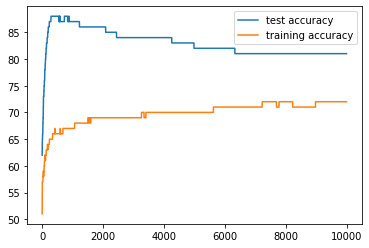

In [13]:
plt.plot(accuracy_te_list,label='test accuracy')
plt.plot(accuracy_tr_list,label='training accuracy')
plt.legend()
plt.show()

In [14]:
max(accuracy_te_list)

tensor(88)